Here is a simpler example of the use of LIME for image classification by using Keras (v2 or greater)

In [1]:
import os
import keras
from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
print('Notebook run using keras:', keras.__version__)

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


('Notebook run using keras:', '2.1.6')


# Using Inception
Here we create a standard InceptionV3 pretrained model and use it on images by first preprocessing them with the preprocessing tools

In [2]:
inet_model = inc_net.InceptionV3()

In [3]:
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(299, 299))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = inc_net.preprocess_input(x)
        out.append(x)
    return np.vstack(out)

## Let's see the top 5 prediction for some image

(u'n02133161', u'American_black_bear', 0.63716)
(u'n02105056', u'groenendael', 0.031818103)
(u'n02104365', u'schipperke', 0.029944422)
(u'n01883070', u'wombat', 0.028509434)
(u'n01877812', u'wallaby', 0.0250936)


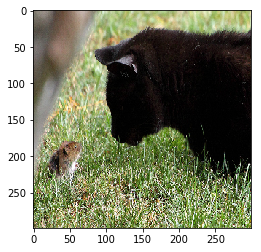

In [4]:
images = transform_img_fn([os.path.join('data','cat_mouse.jpg')])
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(images[0] / 2 + 0.5)
preds = inet_model.predict(images)
for x in decode_predictions(preds)[0]:
    print(x)

## Explanation
Now let's get an explanation

In [5]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image

In [40]:
explainer = lime_image.LimeImageExplainer()

hide_color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels. Here, we set it to 0 (in the representation used by inception model, 0 means gray)

In [43]:
%%time
explanation = explainer.explain_instance(images[0], 
                                         inet_model.predict,
                                         top_labels=5,
                                         hide_color=0,
                                         num_samples=200)

Intercept -0.010237122822590929
Prediction_local [0.01179529]
Right: 0.025093595
Intercept -0.01184033384692542
Prediction_local [0.01296791]
Right: 0.028509384
Intercept -0.04853512587351915
Prediction_local [0.09429534]
Right: 0.029944427
Intercept -0.019833233016341528
Prediction_local [0.06490801]
Right: 0.03181812
Intercept -0.13871234967788576
Prediction_local [0.60553008]
Right: 0.6371601
CPU times: user 6min 22s, sys: 23.3 s, total: 6min 46s
Wall time: 55.3 s


In [28]:
sorted(explanation.intercept, reverse=True)

[295, 224, 223, 106, 104]

In [29]:
from lime import imagenet_mapping

decoded = imagenet_mapping.get_imagenet_labels(decode_predictions(preds)[0])
for d in decoded:
    print d

(u'American_black_bear', 295, 0.63716)
(u'groenendael', 224, 0.031818103)
(u'schipperke', 223, 0.029944422)
(u'wombat', 106, 0.028509434)
(u'wallaby', 104, 0.0250936)


In [30]:
# local_pred should be the probability that, according
# to the LINEAR MODEL, the original image belongs to
# the class given by Inception_v3 (class = 295)
print explanation.local_pred

[0.58363711]


In [10]:
# :::::::::::::::: 1 local_exp for each label to explain :::::::::::::::::
# 
# local_exp is a sorted list of tuples, where each tuple (x,y) corresponds
# to the feature id (x) and the local weight (y). The list is sorted by
# decreasing absolute value of y.

for k in explanation.local_exp:
    print(k, sorted(explanation.local_exp[k], reverse=True)[:5])

(104, [(54, 8.439735848751456e-05), (53, -0.0003266689046568949), (52, -0.00032298881324559214), (51, 0.0007834948201391552), (50, 0.0004620797150720101)])
(224, [(54, 0.010308314633334321), (53, 0.013197609749232722), (52, 0.018283328634747957), (51, -0.012458071831807895), (50, -0.004966262531029183)])
(106, [(54, 0.0004035063234196997), (53, -0.0002979995582800936), (52, -0.0005823233721291299), (51, 0.0007460702021444584), (50, 0.0007891334338756619)])
(295, [(54, 0.040170689220583665), (53, -0.04740970696799164), (52, 0.008575846390169431), (51, 0.0032932723663533377), (50, 0.040835371458919356)])
(223, [(54, 0.012960373296094257), (53, 0.012999050779638888), (52, 0.012239453624765076), (51, -0.00458564191094207), (50, -0.0007694301427887114)])


Image classifiers are a bit slow. Notice that an explanation on my Surface Book dGPU took 1min 29s

### Now let's see the explanation for the top class ( Black Bear)

We can see the top 5 superpixels that are most positive towards the class with the rest of the image hidden

In [31]:
from skimage.segmentation import mark_boundaries

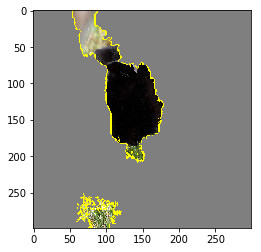

In [32]:
temp, mask = explanation.get_image_and_mask(295, positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Or with the rest of the image present:

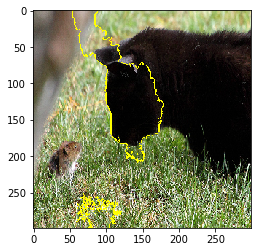

In [33]:
temp, mask = explanation.get_image_and_mask(295, positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))


We can also see the 'pros and cons' (pros in green, cons in red)

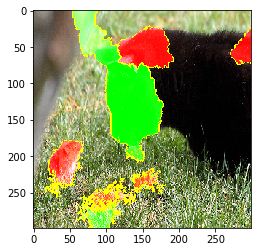

In [34]:
temp, mask = explanation.get_image_and_mask(295, positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Or the pros and cons that have weight at least 0.1

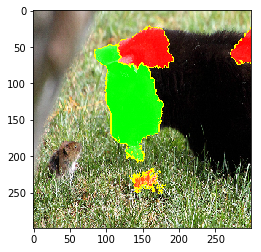

In [35]:
temp, mask = explanation.get_image_and_mask(295, positive_only=False, num_features=1000, hide_rest=False, min_weight=0.1)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

### Let's see the explanation for Wombat

Most positive towards wombat:

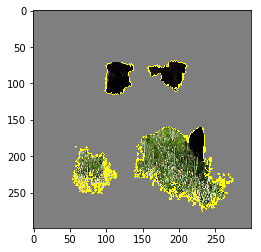

In [36]:
temp, mask = explanation.get_image_and_mask(106, positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Pros and cons:

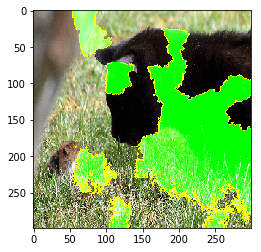

In [37]:
temp, mask = explanation.get_image_and_mask(106, positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
